In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [4]:
import configuration
import model_registry
import data.build
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [5]:
spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 200.0,
    },}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dconst.CORA_FULL,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
    },
    # **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
        # 'use_pretrained_model' : False,
    },
)
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    
print(config.run.use_default_configuration)

True


In [6]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
data_dict[dconst.TRAIN][0].feature_to_idx

{'000': 0,
 '0001': 1,
 '0035': 2,
 '0050': 3,
 '01': 4,
 '0114': 5,
 '02': 6,
 '02139': 7,
 '0229': 8,
 '03': 9,
 '04': 10,
 '0481': 11,
 '05': 12,
 '06': 13,
 '0686': 14,
 '07': 15,
 '08': 16,
 '08855': 17,
 '09': 18,
 '10': 19,
 '100': 20,
 '1000': 21,
 '10036': 22,
 '1024': 23,
 '103': 24,
 '104': 25,
 '109': 26,
 '11': 27,
 '110': 28,
 '1100': 29,
 '111': 30,
 '112': 31,
 '115': 32,
 '12': 33,
 '120': 34,
 '121': 35,
 '125': 36,
 '128': 37,
 '13': 38,
 '130': 39,
 '1330': 40,
 '1331': 41,
 '14': 42,
 '15': 43,
 '150': 44,
 '1515': 45,
 '15213': 46,
 '155': 47,
 '15th': 48,
 '16': 49,
 '160': 50,
 '17': 51,
 '18': 52,
 '180': 53,
 '1879': 54,
 '19': 55,
 '1947': 56,
 '1972': 57,
 '1973': 58,
 '1975': 59,
 '1976': 60,
 '1977': 61,
 '1978': 62,
 '1979': 63,
 '1980': 64,
 '1981': 65,
 '1982': 66,
 '1983': 67,
 '1984': 68,
 '1985': 69,
 '1986': 70,
 '1987': 71,
 '1988': 72,
 '1989': 73,
 '1990': 74,
 '1991': 75,
 '1992': 76,
 '1993': 77,
 '1994': 78,
 '1994a': 79,
 '1995': 80,
 '1996':

In [8]:
model_seed = next(model_seed_generator)

In [9]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'continuous-distribution-shift')

In [10]:
if not torch.cuda.is_available():
    config.training.gpus = 0
config.training.gpus

0

In [40]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])) 
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=8710, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=7, bias=False)
          )
      )
    )
  )
)


In [12]:
model = Ensemble([model], config.ensemble.num_samples, sample_at_eval=config.evaluation.sample)
model.clear_and_disable_cache()
model.eval()

Ensemble(
  (members): ModuleList(
    (0): SemiSupervisedNodeClassification(
      (backbone): GCN(
        (convs): ModuleList(
          (0): BasicBlock(
            (conv): GCNConv
              LinearWithParametrization(
                (linear): Linear(in_features=8710, out_features=64, bias=False)
              )
            (act): LeakyReLU(negative_slope=0.01)
          )
          (1): BasicBlock(
            (conv): GCNConv
              LinearWithParametrization(
                (linear): Linear(in_features=64, out_features=7, bias=False)
              )
          )
        )
      )
    )
  )
)

In [13]:
with torch.no_grad():
    pred_val = model(data_loaders[dconst.VAL].dataset[0])
    y_pred = pred_val.get_predictions().argmax(dim=1)[data_loaders[dconst.VAL].dataset[0].mask]
    y_gnd = data_loaders[dconst.VAL].dataset[0].y[data_loaders[dconst.VAL].dataset[0].mask]
    print((y_pred == y_gnd).float().mean())
    

tensor(0.8357)


In [14]:
from data.transform import PerturbationTransform

In [15]:
data_ood_val_ber = PerturbationTransform(noise_type='bernoulli', p=.5)(data_loaders[dconst.OOD_VAL].dataset[0])

In [16]:

data_train, data_val = data_loaders[dconst.TRAIN].dataset[0], data_loaders[dconst.VAL].dataset[0]
with torch.no_grad():
    pred_train = model(data_train)
    pred_val = model(data_val)


In [17]:
density_model = get_density_model(
    density_type='GaussianPerClass',
    covariance='diag',
    regularization=False,
    fit_val=True,
)
density_model.fit(
    pred_train.get_features(-2)[data_train.mask], 
    pred_train.get_predictions()[data_train.mask], 
    pred_val.get_features(-2)[data_val.mask],
    pred_val.get_predictions()[data_val.mask],
)

In [18]:
with torch.no_grad():
    features_ood_val = model(data_ood_val_ber).get_features(-2)
    density_ood_val = density_model(features_ood_val)

In [19]:
roc_auc_score(
    (~data_ood_val_ber.is_out_of_distribution).cpu().numpy()[data_ood_val_ber.mask],
    density_ood_val.cpu().numpy()[data_ood_val_ber.mask],
)

0.5948151237142063

## Vary success probability

In [20]:
ps, aurocs_density = [], []
aurocs_max_score = []

for p in tqdm(np.linspace(0.0, 1.0, 100)):
    for _ in range(10):
        data_p = PerturbationTransform(noise_type='bernoulli', p=p, seed=np.random.randint(0xFFFFFF))(data_loaders[dconst.OOD_VAL].dataset[0])
        ps.append(p)
        with torch.no_grad():
            pred_p = model(data_p, remove_edges=True)
            density_p = density_model(pred_p.get_features(-2))
            aurocs_density.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
        
    
    

100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


In [21]:
avg_sparsity = ((data_loaders[dconst.TRAIN].dataset[0].x > 0).sum(1) / data_loaders[dconst.TRAIN].dataset[0].x.size(1)).mean()
max_sparsity = ((data_loaders[dconst.TRAIN].dataset[0].x > 0).sum(1) / data_loaders[dconst.TRAIN].dataset[0].x.size(1)).max()

(array([101., 431., 809., 513., 172.,  56.,  24.,  10.,   5.,   4.]),
 array([0.00022962, 0.00244546, 0.00466131, 0.00687715, 0.009093  ,
        0.01130884, 0.01352468, 0.01574053, 0.01795637, 0.02017222,
        0.02238806], dtype=float32),
 <BarContainer object of 10 artists>)

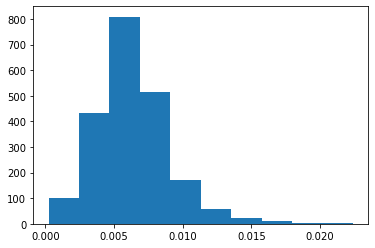

In [22]:
instance_sparsity = (data_loaders[dconst.TRAIN].dataset[0].x > 0).sum(1) / data_loaders[dconst.TRAIN].dataset[0].x.size(1)
fig, ax = plt.subplots()
ax.hist(instance_sparsity.cpu().numpy())

Text(0, 0.5, 'AUC-ROC')

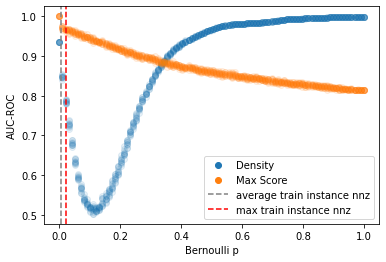

In [23]:
fig, ax = plt.subplots()
ax.scatter(ps, aurocs_density, alpha=.1, c='tab:blue')
ax.scatter([], [], label='Density', c='tab:blue')
ax.scatter(ps, aurocs_max_score, alpha=.1, c='tab:orange')
ax.scatter([], [], label='Max Score', c='tab:orange')
ax.axvline(avg_sparsity, ls='--', label='average train instance nnz', c='grey')
ax.axvline(max_sparsity, ls='--', label='max train instance nnz', c='red')
ax.legend()
ax.set_xlabel('Bernoulli p')
ax.set_ylabel('AUC-ROC')

## Distribution on discriminative features

In [24]:
# Find discriminative features by looking at svd

In [25]:
u, s, v = np.linalg.svd(model.get_weights()['member0.backbone.conv0.lin.weight'].detach().cpu().numpy(), full_matrices=False)

In [26]:
idx_to_feature = {v : k for k, v in data_dict[dconst.TRAIN][0].feature_to_idx.items()}

In [27]:
s

array([7.3500643 , 7.2486315 , 6.9464374 , 6.8717046 , 6.6502132 ,
       6.07743   , 5.928793  , 0.62572145, 0.5676463 , 0.42227274,
       0.41436982, 0.39672515, 0.37418535, 0.34894034, 0.3271857 ,
       0.30382672, 0.29163814, 0.28520247, 0.2714197 , 0.23986183,
       0.22537352, 0.20999251, 0.2007187 , 0.18866901, 0.17828143,
       0.17053044, 0.16343138, 0.14406781, 0.13307981, 0.12777345,
       0.12572554, 0.11923011, 0.1133079 , 0.10570592, 0.09991175,
       0.09576888, 0.09297574, 0.08967987, 0.08709768, 0.08072134,
       0.07573973, 0.07477368, 0.06788231, 0.0656491 , 0.0639345 ,
       0.05901476, 0.05781831, 0.05429827, 0.04771967, 0.04135595,
       0.0403362 , 0.02915326, 0.02440181, 0.02264988, 0.02093903,
       0.01977686, 0.01861701, 0.01720856, 0.01640318, 0.01431907,
       0.01341079, 0.01323337, 0.01213536, 0.01091178], dtype=float32)

In [28]:
discriminative_tokens = set()

num_svs = 7
num_tokens = 5
for tk in (-np.abs(v[:num_svs, ])).argsort()[:, :num_tokens].flatten():
    discriminative_tokens.add(tk)
    
discriminative_tokens = sorted(list(discriminative_tokens))

In [29]:
', '.join([idx_to_feature[tk] for tk in discriminative_tokens])

'bayesian, case, decision, error, evolutionary, ga, genetic, ilp, inductive, knowledge, learning, methods, network, networks, neural, policy, probability, reinforcement, theory, trees'

In [30]:
nnz = (data_loaders[dconst.TRAIN].dataset[0].x[:, discriminative_tokens] > 0).sum(1) / len(discriminative_tokens)

nnz_avg = nnz.mean()
nnz_max = nnz.max()

In [31]:
nnz_avg, nnz_max

(tensor(0.1184), tensor(0.4000))

In [32]:
ps, aurocs_density = [], []
aurocs_max_score = []


for p in tqdm(np.linspace(0.0, 1.0, 100)):
    for _ in range(10):
        data_p = PerturbationTransform(noise_type='bernoulli', p=p, seed=np.random.randint(0xFFFFFF))(data_loaders[dconst.OOD_VAL].dataset[0])
        
        mask = torch.zeros_like(data_p.x)
        mask[:, discriminative_tokens] = 1.0
        data_p.x *= mask
        ps.append(p)
        with torch.no_grad():
            pred_p = model(data_p, remove_edges=True)
            density_p = density_model(pred_p.get_features(-2))
            aurocs_density.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
        

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


Text(0, 0.5, 'AUC-ROC')

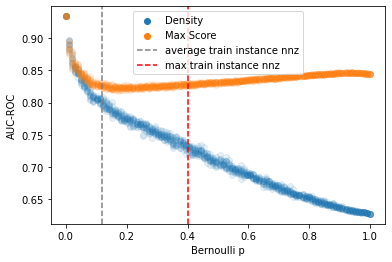

In [33]:
fig, ax = plt.subplots()
ax.scatter(ps, aurocs_density, alpha=.1, c='tab:blue')
ax.scatter([], [], label='Density', c='tab:blue')
ax.scatter(ps, aurocs_max_score, alpha=.1, c='tab:orange')
ax.scatter([], [], label='Max Score', c='tab:orange')
ax.axvline(nnz_avg, ls='--', label='average train instance nnz', c='grey')
ax.axvline(nnz_max, ls='--', label='max train instance nnz', c='red')
ax.legend()
ax.set_xlabel('Bernoulli p')
ax.set_ylabel('AUC-ROC')

# Model class conditional counts

In [34]:
ps = {}
X, y = data_dict[dconst.TRAIN][0].x, data_dict[dconst.TRAIN][0].y

for class_idx in range(y[data_dict[dconst.TRAIN][0].mask].max() + 1):
    ps[class_idx] = (X[y == class_idx] > 0).float().mean(dim=0).detach().cpu().numpy()
    
    


In [35]:
aurocs_density, aurocs_max_score = [], []

for c, p_c in tqdm(ps.items(), 'drawing from class conditional'):
    aurocs_density_c, aurocs_max_score_c = [], []
    for _ in range(10):
        data_p = PerturbationTransform(noise_type='bernoulli', p=.5, seed=np.random.randint(0xFFFFFF))(data_loaders[dconst.OOD_VAL].dataset[0])
        noise = np.random.rand(int(data_p.is_out_of_distribution.sum()), data_p.x.size(1))
        success = (noise <= p_c[None, :]).astype(float)
        success /= np.linalg.norm(success, axis=1, keepdims=True)        
        data_p.x[data_p.is_out_of_distribution] = torch.from_numpy(success).float()
        
        with torch.no_grad():
            pred_p = model(data_p, remove_edges=True)
            density_p = density_model(pred_p.get_features(-2))
            aurocs_density_c.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score_c.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
    aurocs_density.append(aurocs_density_c)
    aurocs_max_score.append(aurocs_max_score_c)
    

drawing from class conditional: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


In [36]:
idx_to_label = {v : k for k, v in data_dict[dconst.TRAIN][0].label_to_idx.items()}

In [37]:
df = pd.DataFrame({
    'Density' : np.array(aurocs_density).flatten(),
    'Max Score' : np.array(aurocs_max_score).flatten(),
    'Label' : [idx_to_label[l].split('/')[-1] for l in np.array([[c for _ in arr] for c, arr in enumerate(aurocs_density)]).flatten()],
})

[Text(0, 0, 'Case-Based'),
 Text(1, 0, 'Theory'),
 Text(2, 0, 'Genetic_Algorithms'),
 Text(3, 0, 'Probabilistic_Methods'),
 Text(4, 0, 'Neural_Networks'),
 Text(5, 0, 'Rule_Learning'),
 Text(6, 0, 'Reinforcement_Learning')]

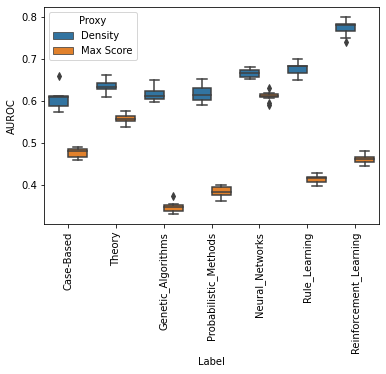

In [38]:
fig, ax = plt.subplots()
sns.boxplot(data=df.melt(id_vars='Label', var_name='Proxy', value_name='AUROC'), x='Label', hue='Proxy', y='AUROC', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [39]:
for c, p in ps.items():
    print(idx_to_label[c].split('/')[-1], ':',  ', '.join(f'{idx_to_feature[tk]} : ({p[tk] * 100:.1f}%)' for tk in (-p).argsort()[:5]))

Case-Based : based : (68.0%), paper : (66.4%), learning : (50.6%), case : (47.1%), reasoning : (39.4%)
Theory : learning : (71.2%), algorithm : (50.0%), paper : (47.0%), results : (38.7%), algorithms : (36.4%)
Genetic_Algorithms : genetic : (74.1%), paper : (50.7%), problem : (41.6%), algorithms : (39.6%), results : (38.2%)
Probabilistic_Methods : paper : (43.6%), bayesian : (38.2%), model : (36.8%), algorithm : (31.4%), models : (31.4%)
Neural_Networks : neural : (51.7%), network : (43.7%), networks : (40.5%), learning : (39.7%), paper : (37.6%)
Rule_Learning : learning : (68.8%), paper : (59.8%), algorithm : (42.9%), problem : (42.9%), results : (38.4%)
Reinforcement_Learning : learning : (83.1%), reinforcement : (65.4%), paper : (58.0%), problem : (38.5%), based : (34.6%)


# Swap features from classes


In [41]:
# Use edges this time...

In [50]:
from copy import deepcopy

In [64]:
df_swap = {}

num_classes = int(data_dict[dconst.TRAIN][0].y.max() + 1)
for src_class in tqdm(range(num_classes), 'Source class...'):
    mask_target = (data_dict[dconst.OOD_VAL][0].y != src_class) # & (data_dict[dconst.OOD_VAL][0].mask) & (data_dict[dconst.OOD_VAL][0].is_out_of_distribution)
    mask_src = (data_dict[dconst.OOD_VAL][0].y == src_class) & (data_dict[dconst.OOD_VAL][0].mask)
    
    for _ in range(10):
        sample_src = np.random.choice(torch.where(mask_src)[0].cpu().numpy(), int(mask_target.sum()), replace=True)

        data_ood = data_dict[dconst.OOD_VAL][0].clone()
        data_ood.x[mask_target] = data_ood.x[sample_src]
        
        with torch.no_grad():
            pred_ood = model(data_ood)
            density_ood = density_model(pred_ood.get_features(-2))
            
            
            # Consider all ID samples and the target mask
            auroc_density = roc_auc_score(
                (~(data_ood.is_out_of_distribution & mask_target)).cpu().numpy()[data_ood.mask],
                density_ood.cpu().numpy()[data_ood.mask],
            )
            auroc_max_score = roc_auc_score(
                (~(data_ood.is_out_of_distribution & mask_target)).cpu().numpy()[data_ood.mask],
                pred_ood.get_predictions().cpu().numpy().max(axis=1)[data_ood.mask],
            )
            print(auroc_density, auroc_max_score)
            
            
            
            
        
        break
    
    
    

Source class...:  14%|█▍        | 1/7 [00:00<00:04,  1.39it/s]

0.49594988344988344 0.5153117715617717


Source class...:  29%|██▊       | 2/7 [00:01<00:03,  1.48it/s]

0.48384195783576595 0.49091110128261833


Source class...:  43%|████▎     | 3/7 [00:02<00:02,  1.44it/s]

0.4720156555772994 0.47669727532741224


Source class...:  57%|█████▋    | 4/7 [00:02<00:02,  1.48it/s]

0.4692261309488793 0.4473866109771163


Source class...:  71%|███████▏  | 5/7 [00:03<00:01,  1.55it/s]

0.4833251674016005 0.4831455169034787


Source class...:  86%|████████▌ | 6/7 [00:03<00:00,  1.58it/s]

0.4997668503603222 0.48579200226084496


Source class...: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

0.49632138694638694 0.5152607808857809
